In [ ]:
words = open('../names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [ ]:
bi = {}
for word in words[:1]:
    w = ['.', '.'] + list(word) + ['.']

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        print(f"{ch1} {ch2} -> {ch3}")


. . -> e
. e -> m
e m -> m
m m -> a
m a -> .


In [ ]:
import torch
N = torch.zeros((27, 27, 27), dtype=torch.int32)
N.dtype

torch.int32

## tigram counting method

In [ ]:
chars = ['.'] + sorted(set(''.join(words)))
stoi = {k:i for i, k in enumerate(chars)}
itos = {v:k for k, v in stoi.items()}

In [ ]:

for word in words:
    w = ['.', '.'] + list(word) + ['.']

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx = (stoi[ch1], stoi[ch2], stoi[ch3])
        N[idx] = N[idx] + 1



In [ ]:
## TODO plot the N matrix 
## AIM: to show (a, b) -> c in a 2d landscape

In [ ]:
N = (N + 1).float()
P = N / N.sum(2, keepdim=True) # use softmax over the third dim
P.shape

torch.Size([27, 27, 27])

### inference

In [ ]:
for i in range(5):
    out = []
    idx = 0,0
    while True:
        p = P[idx]
        
        new = torch.multinomial(p, num_samples=1, replacement=True).item()
        
        idx = idx[1],new
        if new == 0:
            break
        out.append(itos[new])
        
    print(''.join(out))

cai
paundenya
esyn
ada
nourynn


### loss

In [ ]:
n = 0 
loss = 0
for word in words[:1]:
    w = ['.', '.'] + list(word) + ['.']

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        idx = (stoi[ch1], stoi[ch2], stoi[ch3])
        loss += torch.log(P[idx])
        n += 1

nll = -loss/n
print(f"{nll=}")

nll=tensor(2.0956)


##  trigram linear

In [ ]:
import torch.nn.functional as F

In [ ]:
for word in words[:3]:
    w = ['.', '.'] + list(word) + ['.']

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        print(ch1, ch2, ch3)
      

. . e
. e m
e m m
m m a
m a .
. . o
. o l
o l i
l i v
i v i
v i a
i a .
. . a
. a v
a v a
v a .


In [ ]:
X1, X2, Y = [], [], []
for word in words:
    w = ['.', '.'] + list(word) + ['.']

    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        X1.append(stoi[ch1])
        X2.append(stoi[ch2]) 
        Y.append(stoi[ch3])
      
assert len(X1) == len(X2) == len(Y)


In [ ]:
X1 = torch.tensor(X1)
X2 = torch.tensor(X2)
Y = torch.tensor(Y)

In [ ]:
x1_enc = F.one_hot(X1, num_classes=27).float()
x2_enc = F.one_hot(X2, num_classes=27).float()

assert x1_enc.shape  == x2_enc.shape

In [ ]:
x1_enc[:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
X1[:3]

[0, 0, 5]

In [ ]:
nelem = x1_enc.shape[0]

In [ ]:
W1 = torch.randn((27,27), requires_grad=True)
W2 = torch.randn((27,27), requires_grad=True)
assert W1.grad == W2.grad == None

In [ ]:
count = torch.exp(x1_enc @ W1) + torch.exp(x2_enc @ W2)
count

tensor([[ 5.5603,  3.7105,  1.5655,  ...,  1.6482,  1.8491,  2.1499],
        [ 2.0274,  6.5663,  4.5169,  ...,  2.8357,  5.2976,  2.8400],
        [ 1.6525,  2.2142,  1.9421,  ...,  2.9356,  7.5378,  3.2369],
        ...,
        [12.2529,  1.7346,  8.4385,  ...,  3.3317,  0.7511,  0.6818],
        [ 0.7025,  0.9824,  1.4958,  ...,  5.6347,  1.2429,  0.7609],
        [12.0355,  4.9146,  8.5180,  ...,  4.4695,  2.6402,  2.7897]],
       grad_fn=<AddBackward0>)

In [ ]:
prob = count / count.sum(1, keepdims=True)

In [ ]:
loss = -prob[torch.arange(nelem), Y].log().mean() + 0.01 * (W1**2 + W2**2).mean()
loss

tensor(3.4874, grad_fn=<AddBackward0>)

In [ ]:
for k in range(1000):
    counts = torch.exp(x1_enc @ W1) + torch.exp(x2_enc @ W2)
    prob = counts / counts.sum(1, keepdim=True)

    loss = -prob[torch.arange(nelem), Y].log().mean() + 0.01 * (W1**2).mean() + 0.01 * (W2**2).mean()

    
    if  k%100 == 0:
        print(loss.item())
    W1.grad, W2.grad = None, None
    
    loss.backward()

    W1.data += -50*2 * W1.grad
    W2.data += -50*2 * W2.grad
    

3.4874086380004883
2.4660487174987793
2.44608736038208
2.4385883808135986
2.4353103637695312
2.433823347091675
2.432694911956787
2.4324140548706055
2.432297706604004
2.4322376251220703


In [ ]:
for i in range(5):
    out = []
    idx = 0,0
    while True:
        X1_enc = F.one_hot(torch.tensor([idx[0]]), num_classes=27).float()
        X2_enc = F.one_hot(torch.tensor([idx[1]]), num_classes=27).float()

        counts = torch.exp(X1_enc @ W1) + torch.exp(X2_enc @ W2)

        prob = counts / counts.sum(1, keepdim=True)
        
        new = torch.multinomial(prob, num_samples=1, replacement=True).item()
        
        idx = idx[1],new
        if new == 0:
            break
        out.append(itos[new])
        
    print(''.join(out))

domzy
ttylivino
varkana
pein
ahlay


## with data split, with pytorch functions

In [ ]:
idxs = torch.randperm(nelem)
rand_idx = [int(nelem*.8), int(nelem*.9)]
rand_idx

[182516, 205331]

In [ ]:
trn_idx, tst_idx, vld_idx = idxs[:rand_idx[0]], idxs[rand_idx[0]:rand_idx[1]], idxs[rand_idx[1]:]

In [ ]:
X1_trn, X2_trn, Y_trn = X1[trn_idx], X2[trn_idx], Y[trn_idx]
X1_tst, X2_tst, Y_tst = X1[tst_idx], X2[tst_idx], Y[tst_idx]
X1_vld, X2_vld, Y_vld = X1[vld_idx], X2[vld_idx], Y[vld_idx]
assert X1_trn.nelement()+ X1_tst.nelement() + X1_vld.nelement() == nelem

In [ ]:
X1_trn[:20], X2_trn[:20]

(tensor([ 0,  1, 18,  0, 21, 12, 15,  0, 14,  1,  3,  0,  9,  0, 13,  0,  1, 21,
         14,  0]),
 tensor([ 0,  8,  9,  0,  3,  5, 19, 20,  7, 14,  8,  1,  5,  0,  1, 12, 26, 12,
          9,  2]))

In [ ]:
(Y == 1).sum()

tensor(33885)

In [ ]:
W1 = torch.randn((27,27), requires_grad=True)
W2 = torch.randn((27,27), requires_grad=True)
assert W1.grad == W2.grad == None

In [ ]:
def forward_pass(X1, X2):
    X_enc = W1[X1] + W2[X2] 
    counts = torch.exp(X_enc)
    prob = counts / counts.sum(1, keepdim=True)
    return prob

In [ ]:
pred = forward_pass(X1_trn, X2_trn)

In [ ]:
assert pred.shape[0] == X1_trn.shape[0]
assert pred.shape[1] == 27

In [ ]:
def loss(pred, Y):
    return F.cross_entropy(pred, Y)

In [ ]:
l = loss(pred, Y_trn)
l

tensor(3.2970, grad_fn=<NllLossBackward0>)

In [ ]:
W1 = torch.randn((27,27), requires_grad=True)
W2 = torch.randn((27,27), requires_grad=True)
assert W1.grad == W2.grad == None
lr = -50*2
for i in range(5000):
    pred_trn = forward_pass(X1_trn, X2_trn)
    #print(pred.shape)
    loss_trn = loss(pred_trn, Y_trn) + 0.01125 * (W1**2 + W2**2).mean()


    loss_trn.backward()

    W1.data += lr * W1.grad
    W2.data += lr * W2.grad
    
    W1.grad, W2.grad = None, None

    pred_vld = forward_pass(X1_vld, X2_vld)
    loss_vld = loss(pred_vld, Y_vld)

    if i % 200 == 0:
        print(f"{i} -> train loss:{loss_trn.item():.4f}  valid_loss:{loss_vld.item():.4f}")
        
pred_tst = forward_pass(X1_tst, X2_tst)
loss_tst = loss(pred_tst, Y_tst)
accu = (pred_tst.argmax(1) == Y_tst).float().mean()
print(f"test loss:{loss_tst.item():.4f}  accuracy:{accu.item():.4f}")

0 -> train loss:3.3228  valid_loss:3.2972
200 -> train loss:3.1316  valid_loss:3.1185
400 -> train loss:3.1173  valid_loss:3.1068
600 -> train loss:3.1139  valid_loss:3.1026
800 -> train loss:3.1122  valid_loss:3.0999
1000 -> train loss:3.1098  valid_loss:3.0968
1200 -> train loss:3.1083  valid_loss:3.0946
1400 -> train loss:3.1078  valid_loss:3.0939
1600 -> train loss:3.1077  valid_loss:3.0937
1800 -> train loss:3.1075  valid_loss:3.0935
2000 -> train loss:3.1075  valid_loss:3.0935
2200 -> train loss:3.1075  valid_loss:3.0935
2400 -> train loss:3.1075  valid_loss:3.0935
2600 -> train loss:3.1075  valid_loss:3.0935
2800 -> train loss:3.1075  valid_loss:3.0935
3000 -> train loss:3.1075  valid_loss:3.0935
3200 -> train loss:3.1075  valid_loss:3.0935
3400 -> train loss:3.1075  valid_loss:3.0935
3600 -> train loss:3.1075  valid_loss:3.0935
3800 -> train loss:3.1075  valid_loss:3.0935
4000 -> train loss:3.1075  valid_loss:3.0935
4200 -> train loss:3.1075  valid_loss:3.0935
4400 -> train los

In [ ]:
result = ""
for i in range(5000):
    out = ""
    idx = 0,0
    while True:
        X1_enc = torch.tensor([idx[0]])
        X2_enc = torch.tensor([idx[1]])

        prob = forward_pass(X1_enc, X2_enc)
        
        new = torch.multinomial(prob, num_samples=1, replacement=True).item()
        
        idx = idx[1],new
        if new == 0:
            break
        out += itos[new]
    #print(out)
    result = result+ out
    #print(''.join(out))

In [ ]:
result = list(''.join(result))
from collections import Counter
counter = Counter(result)
counter

Counter({'a': 6451,
         'n': 2898,
         'i': 1855,
         'r': 1816,
         'e': 206,
         'l': 205,
         's': 27,
         'x': 20,
         'y': 18,
         'z': 17,
         'o': 15,
         'f': 13,
         'm': 13,
         'u': 13,
         'd': 12,
         'b': 11,
         'v': 11,
         'q': 11,
         'w': 10,
         'c': 10,
         'k': 9,
         'h': 9,
         'g': 9,
         'p': 9,
         't': 8,
         'j': 8})

In [ ]:
n = sum(counter.values())
op_freq = [counter[itos[i]] / n for i in range(27)]

In [ ]:
dis = [(Y_trn == j).sum().item()/Y_trn.nelement() for j in range(27)]
len(dis)

27

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

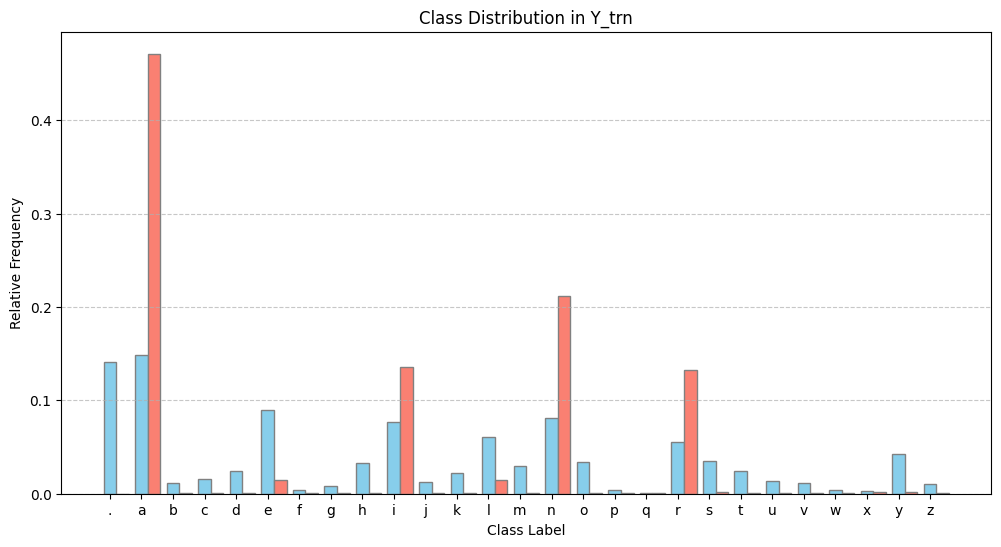

In [ ]:
custom_labels = [f'{itos[j]}' for j in range(27)]
num_bins = 27

# Bar width
bar_width = 0.4

# Positions of the bars on the x-axis
r1 = np.arange(num_bins)
r2 = [x + bar_width for x in r1]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(r1, dis, color='skyblue', width=bar_width, edgecolor='grey', label='Y_trn')
plt.bar(r2, op_freq, color='salmon', width=bar_width, edgecolor='grey', label='gen')


plt.xlabel('Class Label')
plt.ylabel('Relative Frequency')
plt.title('Class Distribution in Y_trn')
plt.xticks(ticks=range(27), labels=custom_labels,)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Conclusion 
- the linear model is very hard to converge
- op is skewed to wards a
- using big NN model should increase the accuracy